In [92]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# !unzip /content/drive/MyDrive/Colab\ Notebooks/guava.zip -d /content/drive/MyDrive/Colab\ Notebooks/

In [93]:
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt

In [94]:
BATCH_SIZE = 16
IMAGE_SIZE_X = 224
IMAGE_SIZE_Y = 224
NUM_CLASSES = 3
CHANNELS=3
EPOCHS=50

In [95]:
dataset_dir = "/content/drive/MyDrive/Colab Notebooks/Guava"

In [96]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    dataset_dir,
    seed=123,
    shuffle=True,
    image_size=(IMAGE_SIZE_X,IMAGE_SIZE_Y),
    batch_size=BATCH_SIZE
)


Found 185 files belonging to 3 classes.


In [97]:
class_names = dataset.class_names
class_names

['dot', 'healthy', 'rust']

In [98]:
import os

for class_name in class_names:
  class_dir = os.path.join(dataset_dir, class_name)
  num_images = len(os.listdir(class_dir))
  print(f"Class: {class_name}, Number of images: {num_images}")

Class: dot, Number of images: 61
Class: healthy, Number of images: 63
Class: rust, Number of images: 61


In [ ]:
# for image_batch, labels_batch in dataset.take(1):
#     print(image_batch.shape)
#     print(labels_batch.numpy())

In [ ]:
# plt.figure(figsize=(10, 10))
# for image_batch, labels_batch in dataset.take(1):
#     for i in range(12):
#         ax = plt.subplot(3, 4, i + 1)
#         plt.imshow(image_batch[i].numpy().astype("uint8"))
#         plt.title(class_names[labels_batch[i]])
#         plt.axis("off")

In [179]:
# Assuming dataset is available and contains images with labels

# Total number of images in the dataset
total_images = len(dataset)

# Define the sizes based on your dataset
train_size = 0.8
val_size = 0.1
test_size = 0.1

# Calculate actual numbers for splitting
train_count = int(total_images * train_size)  # 148
val_count = int(total_images * val_size)      # 18
test_count = total_images - train_count - val_count  # 18

# Create the training dataset
train_ds = dataset.take(train_count)
print("Training dataset size:", len(train_ds))

# Create the remaining dataset for validation and testing
remaining_ds = dataset.skip(train_count)

# Create the validation dataset
val_ds = remaining_ds.take(val_count)
print("Validation dataset size:", len(val_ds))

# Create the testing dataset
test_ds = remaining_ds.skip(val_count)
print("Testing dataset size:", len(test_ds))

Training dataset size: 9
Validation dataset size: 1
Testing dataset size: 2


In [180]:
def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    assert (train_split + test_split + val_split) == 1

    ds_size = len(ds)

    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)

    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)

    train_ds = ds.take(train_size)
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)

    return train_ds, val_ds, test_ds

In [181]:
train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)

In [182]:
len(train_ds)

9

In [183]:
len(val_ds)

1

In [184]:
len(test_ds)

2

In [185]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [186]:
resize_and_rescale = tf.keras.Sequential([
  layers.Resizing(IMAGE_SIZE_X, IMAGE_SIZE_Y),
  layers.Rescaling(1./255),
])

In [187]:
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.layers import Layer

class RandomBlur(Layer):
    def __init__(self, kernel_size=3, **kwargs):
        super(RandomBlur, self).__init__(**kwargs)
        self.kernel_size = kernel_size

    def call(self, images):
        channels = tf.shape(images)[-1]
        blur_kernel = tf.ones((self.kernel_size, self.kernel_size, channels, 1)) / (self.kernel_size ** 2)

        return tf.nn.depthwise_conv2d(
            images, blur_kernel,
            strides=[1, 1, 1, 1], padding='SAME'
        )

data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal_and_vertical"),
    layers.RandomRotation(0.2),
    layers.RandomZoom(0.2),
    layers.RandomBrightness((0.1)),
    layers.RandomContrast(0.1),
    RandomBlur(5),
    layers.GaussianNoise(0.1)
])


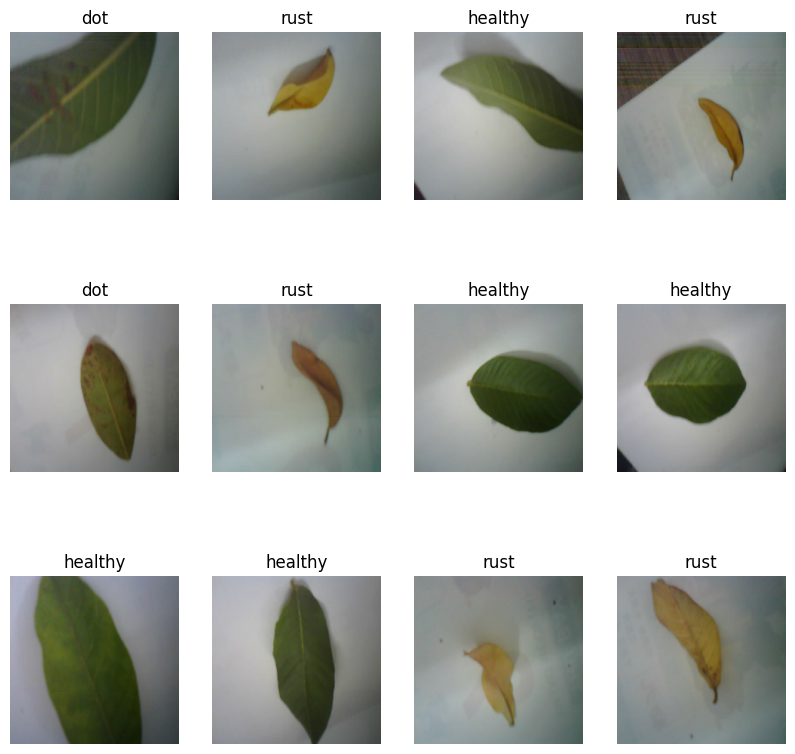

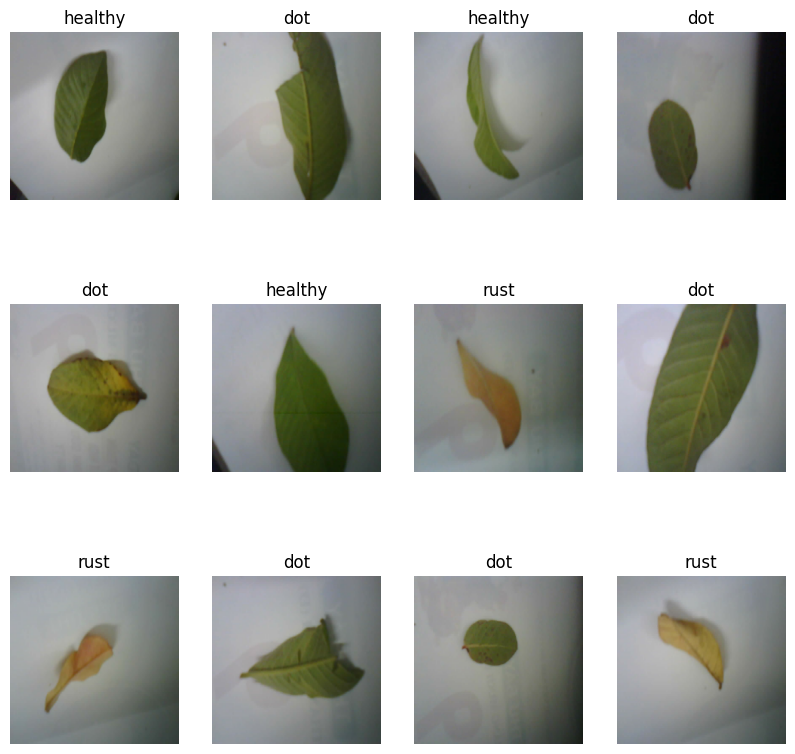

In [188]:
import matplotlib.pyplot as plt

for image_batch, labels_batch in train_ds.take(1):
  plt.figure(figsize=(10, 10))
  for i in range(12):
    ax = plt.subplot(3, 4, i + 1)
    plt.imshow(image_batch[i].numpy().astype("uint8"))
    plt.title(class_names[labels_batch[i]])
    plt.axis("off")
  plt.show()
  break


for image_batch, labels_batch in dataset.take(1):
  plt.figure(figsize=(10, 10))
  for i in range(12):
    ax = plt.subplot(3, 4, i + 1)
    plt.imshow(image_batch[i].numpy().astype("uint8"))
    plt.title(class_names[labels_batch[i]])
    plt.axis("off")
  plt.show()
  break

In [252]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2

model = Sequential()

# Convolutional layers
model.add(Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=(IMAGE_SIZE_X, IMAGE_SIZE_Y, 3)))
model.add(BatchNormalization())
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.4))

model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.4))

model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.5))

model.add(Conv2D(256, (3, 3), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.5))

# Fully connected layers
model.add(Flatten())
model.add(Dense(512, activation='relu', kernel_regularizer=l2(0.01)))
model.add(Dropout(0.6))
model.add(Dense(256, activation='relu', kernel_regularizer=l2(0.01)))
model.add(Dropout(0.6))
model.add(Dense(NUM_CLASSES, activation='softmax'))

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.0001),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])

model.summary()

Model: "sequential_29"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_56 (Conv2D)                   │ (None, 224, 224, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_53               │ (None, 224, 224, 32)        │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_56 (MaxPooling2D)      │ (None, 112, 112, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_55 (Dropout)                 │ (None, 112, 112, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_57 (Conv2D)                   │ (None, 112, 112, 64)        │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_54               │ (None, 112, 112, 64)        │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_57 (MaxPooling2D)      │ (None, 56, 56, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_56 (Dropout)                 │ (None, 56, 56, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_58 (Conv2D)                   │ (None, 56, 56, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_55               │ (None, 56, 56, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_58 (MaxPooling2D)      │ (None, 28, 28, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_57 (Dropout)                 │ (None, 28, 28, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_59 (Conv2D)                   │ (None, 28, 28, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_56               │ (None, 28, 28, 256)         │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_59 (MaxPooling2D)      │ (None, 14, 14, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_58 (Dropout)                 │ (None, 14, 14, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_18 (Flatten)                 │ (None, 50176)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_53 (Dense)                     │ (None, 512)                 │      25,690,624 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_59 (Dropout)                 │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 26,213,059 (99.99 MB)

 Trainable params: 26,212,099 (99.99 MB)

 Non-trainable params: 960 (3.75 KB)

In [226]:
# model.compile(
#     optimizer='adam',
#     loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
#     metrics=['accuracy']
# )

In [253]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

# class_weights = {
#     0: 1.0,  # dot
#     1: 1.0,  # healthy
#     2: 1.0,  # mummification
#     3: 1.0   # rust
# }

earlystop = EarlyStopping(
    monitor='val_loss',
    min_delta=0,
    patience=10,
    verbose=1,
    restore_best_weights=True
)

# checkpoint = ModelCheckpoint(
#     '/content/guava-w-aug-esp32.h5',
#     monitor='val_loss',
#     save_best_only=True,
#     mode='min',
#     verbose=1
# )

# callbacks = [checkpoint, earlystop]
callbacks = [earlystop]

history = model.fit(
    train_ds,
    batch_size=BATCH_SIZE,
    validation_data=val_ds,
    verbose=1,
    epochs=47,
    # class_weight=class_weights,
    callbacks=callbacks
)
#Note : 47 epochs

Epoch 1/47
9/9 ━━━━━━━━━━━━━━━━━━━━ 23s 1s/step - accuracy: 0.2943 - loss: 19.9147 - val_accuracy: 0.5000 - val_loss: 18.0491
Epoch 2/47
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step - accuracy: 0.3200 - loss: 20.5144 - val_accuracy: 0.6250 - val_loss: 15.2874
Epoch 3/47
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step - accuracy: 0.3613 - loss: 20.9201 - val_accuracy: 0.5625 - val_loss: 14.5142
Epoch 4/47
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - accuracy: 0.4271 - loss: 18.3659 - val_accuracy: 0.5625 - val_loss: 14.7390
Epoch 5/47
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step - accuracy: 0.3724 - loss: 18.3481 - val_accuracy: 0.5625 - val_loss: 14.0236
Epoch 6/47
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 54ms/step - accuracy: 0.3552 - loss: 18.6727 - val_accuracy: 0.6250 - val_loss: 13.7596
Epoch 7/47
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step - accuracy: 0.5426 - loss: 15.5245 - val_accuracy: 0.8750 - val_loss: 13.5025
Epoch 8/47
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 53ms/step - accuracy: 0.4864 - loss: 15.5831 - val_accuracy: 0.6875 - val

In [ ]:
# scores = model.evaluate(test_ds)

In [ ]:
# scores

In [254]:
history

In [255]:
history.params

{'verbose': 1, 'epochs': 47, 'steps': 9}

In [256]:
history.history.keys()

dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss'])

In [257]:
type(history.history['loss'])

list

In [258]:
len(history.history['loss'])

18

In [259]:
history.history['loss'][:5]

[19.821229934692383,
 19.607357025146484,
 20.37441635131836,
 18.06246566772461,
 18.5344181060791]

In [260]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

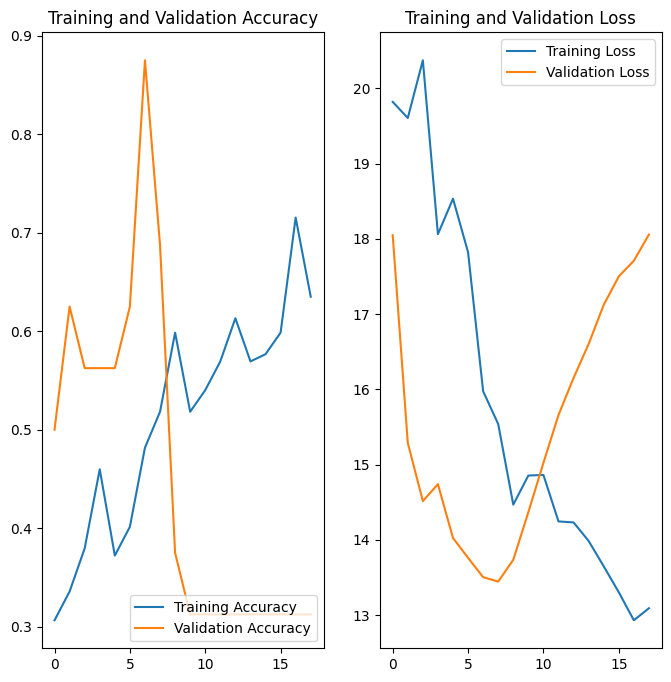

In [261]:
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(range(len(acc)), acc, label='Training Accuracy')
plt.plot(range(len(val_acc)), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(range(len(loss)), loss, label='Training Loss')
plt.plot(range(len(val_loss)), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [132]:
model.save('guava_model.keras')

first image to predict
actual label: dot
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 337ms/step
predicted label: dot


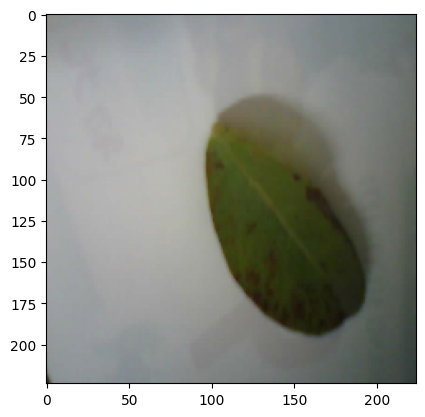

In [246]:
import numpy as np
for images_batch, labels_batch in test_ds.take(1):

    first_image = images_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0].numpy()

    print("first image to predict")
    plt.imshow(first_image)
    print("actual label:",class_names[first_label])

    batch_prediction = model.predict(images_batch)
    print("predicted label:",class_names[np.argmax(batch_prediction[0])])

In [247]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

In [248]:
model.save('/content/my_model.keras')

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 875ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


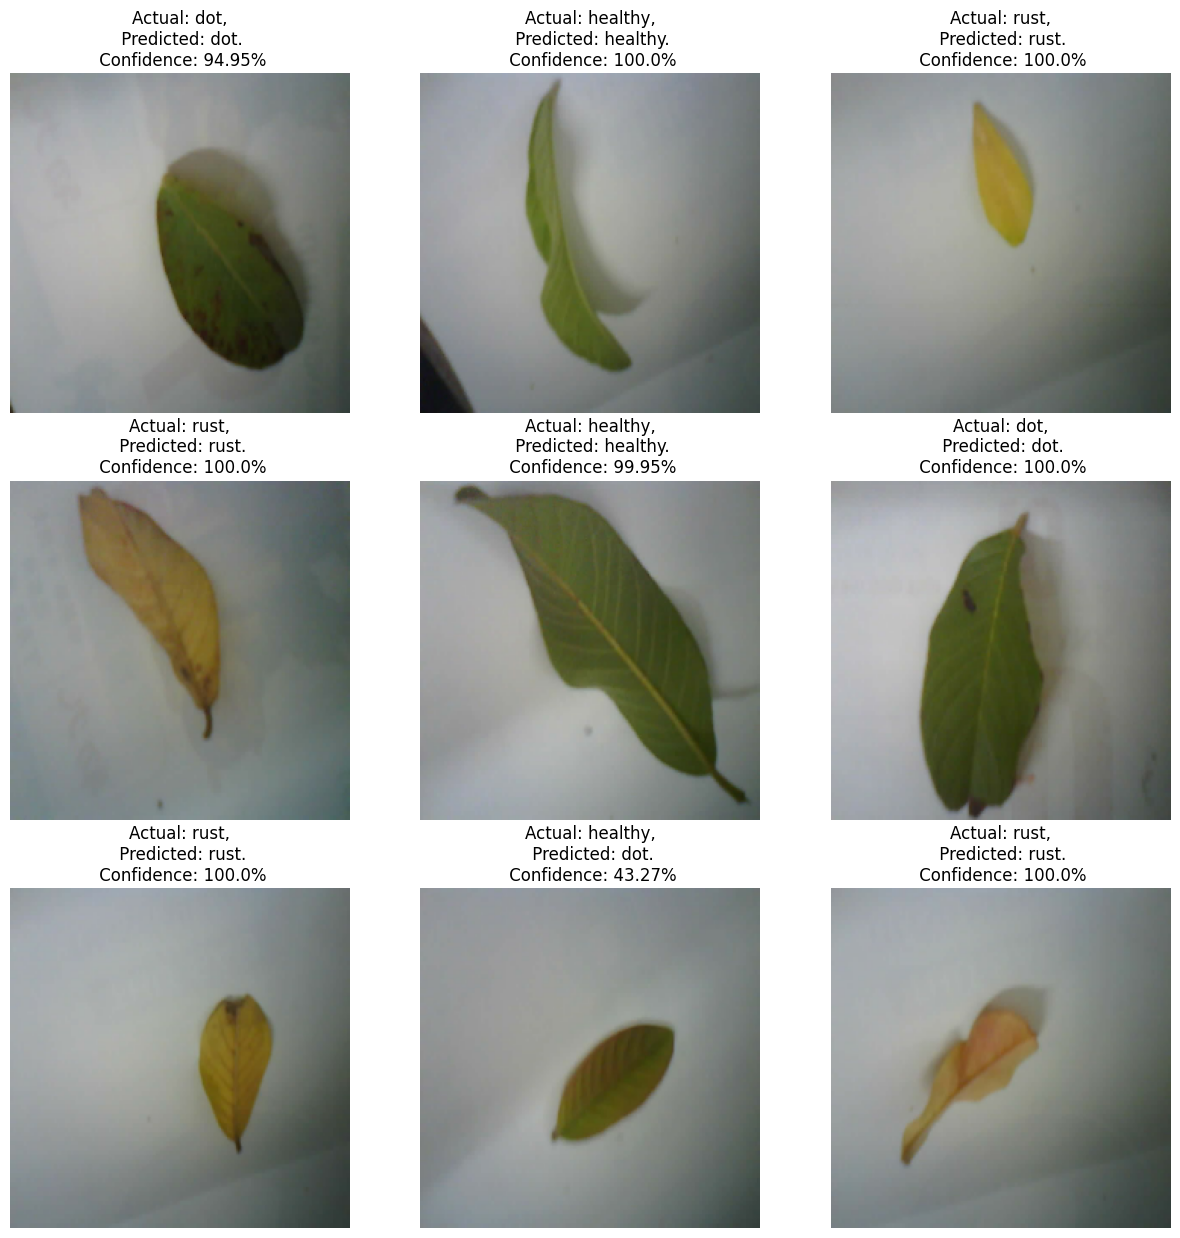

In [249]:
from tensorflow import keras

model = keras.models.load_model('/content/my_model.keras')
plt.figure(figsize=(15, 15))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))

        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]]

        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")

        plt.axis("off")

Saving 20241023141549 (1).jpg to 20241023141549 (1).jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 369ms/step
Image: 20241023141549 (1).jpg
Predicted class: dot
Confidence: 100.0%


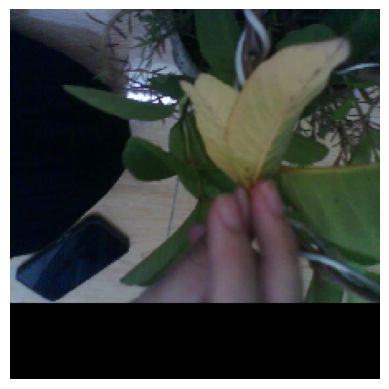

In [251]:

from google.colab import files
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

model = tf.keras.models.load_model('/content/guava_model.keras')

class_names = ['dot', 'healthy', 'rust']

uploaded = files.upload()

for fn in uploaded.keys():
  path = '/content/' + fn
  img = tf.keras.utils.load_img(path, target_size=(224, 224))
  img_array = tf.keras.utils.img_to_array(img)
  img_array = tf.expand_dims(img_array, 0)

  predictions = model.predict(img_array)
  predicted_class = class_names[np.argmax(predictions[0])]
  confidence = round(100 * (np.max(predictions[0])), 2)

  print(f"Image: {fn}")
  print(f"Predicted class: {predicted_class}")
  print(f"Confidence: {confidence}%")
  plt.imshow(img)
  plt.axis('off')
  plt.show()

In [150]:
# Tạo thư mục nếu chưa tồn tại
os.makedirs(model_directory, exist_ok=True)

In [151]:
import os

# Lọc ra các tệp có phần mở rộng .h5 và chỉ lấy phần tên tệp (không có phần mở rộng)
model_files = [f.split('.')[0] for f in os.listdir("/content/model") if f.endswith(".h5")]

# Chuyển đổi các tên tệp thành số nguyên, bỏ qua các tệp không phải số nguyên
model_versions = [int(f) for f in model_files if f.isdigit()]

# Tìm số phiên bản lớn nhất và cộng thêm 1
model_version = max(model_versions, default=0) + 1

# Lưu mô hình với tên phiên bản mới
model.save(f"/content/model/{model_version}.h5")
print(f"Model saved as /content/model/{model_version}.h5")


Model saved as /content/model/1.h5


Use trained model


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 374ms/step


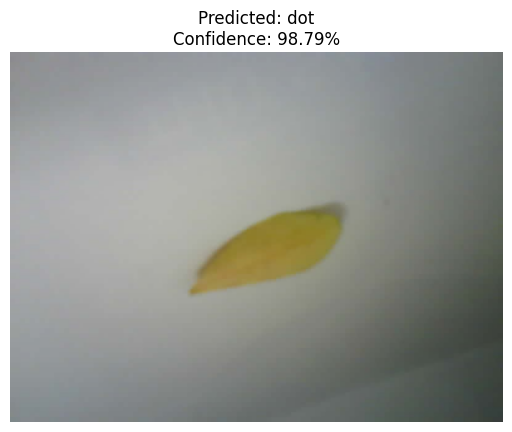

In [153]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import os

# Đường dẫn đến mô hình đã lưu
model_path = "/content/model/1.h5"
model = tf.keras.models.load_model(model_path)

# Các lớp của mô hình
class_names = ['dot', 'healthy', 'rust']

# Hàm xử lý ảnh
def preprocess_image(image_path):
    img = tf.keras.utils.load_img(image_path, target_size=(224, 224))
    img_array = tf.keras.utils.img_to_array(img)
    img_array = tf.expand_dims(img_array, 0)
    img_array /= 255.0
    return img_array

# Hàm dự đoán
def predict_image(image_path):
    if not os.path.exists(image_path):
        raise FileNotFoundError(f"Image file not found at {image_path}")

    img_array = preprocess_image(image_path)
    prediction = model.predict(img_array)

    predicted_class = class_names[np.argmax(prediction[0])]
    confidence = round(100 * np.max(prediction[0]), 2)
    return predicted_class, confidence

# Đường dẫn ảnh cần dự đoán
image_path = "/content/drive/MyDrive/Colab Notebooks/Guava/rust/20241111164713.jpg"  # Đảm bảo tệp tồn tại

# Dự đoán và hiển thị ảnh
try:
    predicted_class, confidence = predict_image(image_path)
    img = tf.keras.utils.load_img(image_path)
    plt.imshow(img)
    plt.title(f"Predicted: {predicted_class}\nConfidence: {confidence}%")
    plt.axis("off")
    plt.show()
except FileNotFoundError as e:
    print(e)
